# Task 1: Regression on ZINC dataset

In [1]:
# For Google Colaboratory
import sys, os
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive/")
    path = "/content/drive/MyDrive/yanming_dissertation/gt_v2/code"
    os.chdir(path)
    !pwd
    !pip install dgl==1.0.0
    !pip install rdkit==2023.09.6

In [2]:
# Libraries
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import networkx as nx
import sys; sys.path.insert(0, 'lib/')
from lib.molecules import Dictionary, MoleculeDataset, MoleculeDGL, Molecule, compute_ncut
import os, datetime
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import numpy as np
import math

In [3]:
# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda")
else:
  device= torch.device("cpu")
print(device)

2.1.2
cpu


## Load Dataset

Loading data...
dataset/ZINC/
Time: 1.699580430984497
num train data : 2000
atom_dict.idx2word : ['C', 'O', 'N', 'F', 'C H1', 'S', 'Cl', 'O -', 'N H1 +', 'Br', 'N H3 +', 'N H2 +', 'N +', 'N -', 'I', 'S -', 'P', 'N H1 -']
atom_dict.word2idx : {'C': 0, 'O': 1, 'N': 2, 'F': 3, 'C H1': 4, 'S': 5, 'Cl': 6, 'O -': 7, 'N H1 +': 8, 'Br': 9, 'N H3 +': 10, 'N H2 +': 11, 'N +': 12, 'N -': 13, 'I': 14, 'S -': 15, 'P': 16, 'N H1 -': 17}
bond_dict.idx2word : ['NONE', 'SINGLE', 'DOUBLE', 'TRIPLE']
bond_dict.word2idx : {'NONE': 0, 'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}
18 4
train[idx].atom_type : tensor([0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 2, 0, 5])
train[idx].atom_type_pe : tensor([ 0,  1,  2,  3,  4,  5,  6,  0,  1,  7,  2,  8,  9, 10, 11, 12,  3, 13,
        14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,  0,  4, 25,  0])
train[idx].bond_type : tensor([[0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 

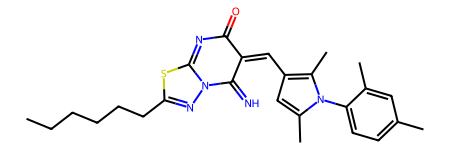

In [5]:
print('Loading data...')
start = time.time()

data_folder_pytorch = 'dataset/ZINC/'
print(data_folder_pytorch)

with open(data_folder_pytorch+"atom_dict.pkl","rb") as f:
    atom_dict=pickle.load(f)
with open(data_folder_pytorch+"bond_dict.pkl","rb") as f:
    bond_dict=pickle.load(f)
with open(data_folder_pytorch+"test.pkl","rb") as f:
    test=pickle.load(f)
with open(data_folder_pytorch+"val.pkl","rb") as f:
    val=pickle.load(f)
with open(data_folder_pytorch+"train.pkl","rb") as f:
    train=pickle.load(f)
print('Time:',time.time()-start)

print('num train data :',len(train))

print('atom_dict.idx2word :',atom_dict.idx2word)
print('atom_dict.word2idx :',atom_dict.word2idx)
print('bond_dict.idx2word :',bond_dict.idx2word)
print('bond_dict.word2idx :',bond_dict.word2idx)

num_atom_type = len(atom_dict.idx2word)
num_bond_type = len(bond_dict.idx2word)
print(num_atom_type, num_bond_type)

idx = 0
print('train[idx].atom_type :',train[idx].atom_type)
print('train[idx].atom_type_pe :',train[idx].atom_type_pe)
print('train[idx].bond_type :',train[idx].bond_type)
print('train[idx].bag_of_atoms :',train[idx].bag_of_atoms)
print('train[idx].smile: ',train[idx].smile)
mol = Chem.MolFromSmiles(train[idx].smile)
mol

## Dataset Statistics

In [11]:
# Organize data into group of of molecules of fixed sized
# Example: train[22] is a list containing all the molecules of size 22
def group_molecules_per_size(dataset):
    mydict={}
    for mol in dataset:
        if len(mol) not in mydict:
            mydict[len(mol)]=[]
        mydict[len(mol)].append(mol)
    return mydict
test_group  = group_molecules_per_size(test)
val_group   = group_molecules_per_size(val)
train_group = group_molecules_per_size(train)
print(len(train_group[28]))

# The biggest molecule in the train set
max_mol_sz= max(list( train_group.keys()))
print('Max num atoms = ', max_mol_sz)

# Print distribution w.r.t. molecule size
def print_distribution(data):
    for nb_atom in range(max_mol_sz+1):
        try:
            print('number of molecule of size {}: \t {}'.format(nb_atom, len(data[nb_atom])))
        except:
            pass

print()
# print('Train'); print_distribution(train_group)
# print('Val'); print_distribution(val_group)
print('Test'); print_distribution(test_group)

85
Max num atoms =  37

Test
number of molecule of size 12: 	 1
number of molecule of size 13: 	 1
number of molecule of size 14: 	 2
number of molecule of size 15: 	 5
number of molecule of size 16: 	 4
number of molecule of size 17: 	 7
number of molecule of size 18: 	 16
number of molecule of size 19: 	 7
number of molecule of size 20: 	 11
number of molecule of size 21: 	 17
number of molecule of size 22: 	 8
number of molecule of size 23: 	 14
number of molecule of size 24: 	 21
number of molecule of size 25: 	 16
number of molecule of size 26: 	 12
number of molecule of size 27: 	 21
number of molecule of size 28: 	 5
number of molecule of size 29: 	 11
number of molecule of size 30: 	 3
number of molecule of size 31: 	 7
number of molecule of size 32: 	 4
number of molecule of size 33: 	 4
number of molecule of size 34: 	 2
number of molecule of size 36: 	 1
